<a href="https://colab.research.google.com/github/develop-insight/AIFFEL_quest_rs/blob/master/GoingDeeper/Go07/2025_05_27_huggingface_setting_max_length.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HuggingFace 커스텀 프로젝트 만들기 [프로젝트]

## 프로젝트 : 커스텀 프로젝트 직접 만들기


실습 코드에서 수행해 본 내용을 토대로, 이번에는 한국어 데이터셋에 도전해보겠습니다.

앞서 본 GLUE benchmark의 한국어 버전 [KLUE benchmark](https://klue-benchmark.com/)를 들어보신 적 있나요?

GLUE와 마찬가지로 한국어 자연어처리에 대한 이해도를 높이기 위해 만들어진 데이터셋 benchmark입니다. 총 8가지의 데이터셋이 있습니다. 다만 이번 시간에 진행할 프로젝트는 KLUE의 dataset을 활용하는 것이 아닌, model(klue/ber-base)를 활용하여 NSMC(Naver Sentiment Movie Corpus) task를 도전해보겠습니다.

모델과 데이터에 관한 정보는 링크를 참조해주세요.

- KLUE/Bert-base: https://huggingface.co/klue/bert-base
- NSMC: https://github.com/e9t/nsmc




### 라이브러리

In [ ]:
import tensorflow
import numpy
import transformers
import datasets

print(tensorflow.__version__)
print(numpy.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.18.0
2.0.2
4.52.2
3.6.0


In [ ]:
import matplotlib.pyplot as plt

import os
import numpy as np
from transformers import Trainer, TrainingArguments

### NSMC 데이터 분석 및 Huggingface dataset 구성


In [ ]:
!pip install --upgrade datasets huggingface_hub fsspec

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [ ]:
import datasets
from datasets import load_dataset

nsmc_dataset = load_dataset("e9t/nsmc")
print(nsmc_dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [ ]:
# 데이터 확인

for i in range(5):
    for col in nsmc_dataset['train'].column_names:
        print(col,":",nsmc_dataset['train'][col][i])
    print("\n")

id : 9976970
document : 아 더빙.. 진짜 짜증나네요 목소리
label : 0


id : 3819312
document : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
label : 1


id : 10265843
document : 너무재밓었다그래서보는것을추천한다
label : 0


id : 9045019
document : 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
label : 0


id : 6483659
document : 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
label : 1




### klue/bert-base model 및 tokenizer 불러오기

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2)

# model = AutoModel.from_pretrained("klue/bert-base")
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer.model_max_length

512

### 위에서 불러온 tokenizer으로 데이터셋을 전처리하고, model 학습 진행해 보기

In [ ]:
def transform(data):
    return tokenizer(
        data['document'],
        truncation = True,
        # padding = 'max_length',
        return_token_type_ids = False,
        )

In [ ]:
nsmc_dataset_tokenized = nsmc_dataset.map(transform,batched=True)
nsmc_dataset_tokenized

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'attention_mask'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [ ]:
nsmc_train = nsmc_dataset_tokenized['train']
nsmc_test = nsmc_dataset_tokenized['test']

#### validation set split

모델 학습을 위해 validation set을 나눔

In [ ]:
split_dataset = nsmc_train.train_test_split(test_size=0.2, seed=42)
train = split_dataset["train"]
valid = split_dataset["test"]

In [ ]:
train

Dataset({
    features: ['id', 'document', 'label', 'input_ids', 'attention_mask'],
    num_rows: 120000
})

In [ ]:
valid

Dataset({
    features: ['id', 'document', 'label', 'input_ids', 'attention_mask'],
    num_rows: 30000
})

In [ ]:
test = nsmc_test

In [ ]:
test

Dataset({
    features: ['id', 'document', 'label', 'input_ids', 'attention_mask'],
    num_rows: 50000
})

길이 분포 확인

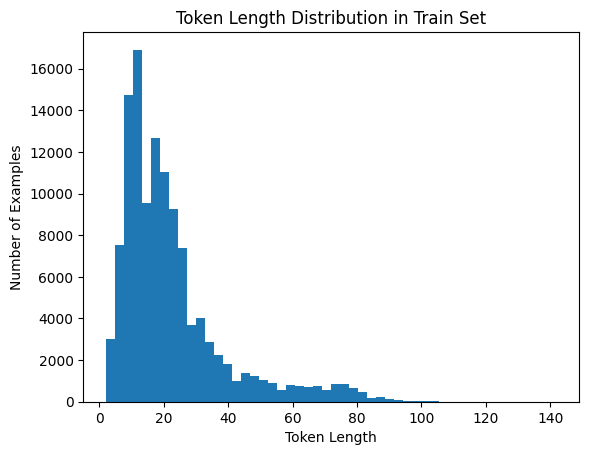

In [ ]:


# 토큰 길이 측정
lengths = [len(example["input_ids"]) for example in train]

# 히스토그램 시각화
plt.hist(lengths, bins=50)
plt.title("Token Length Distribution in Train Set")
plt.xlabel("Token Length")
plt.ylabel("Number of Examples")
plt.show()


In [ ]:
import numpy as np

print(f"최대 길이: {np.max(lengths)}")
print(f"평균 길이: {np.mean(lengths):.2f}")
print(f"95% 이하: {np.percentile(lengths, 95):.0f}")
print(f"99% 이하: {np.percentile(lengths, 99):.0f}")


최대 길이: 142
평균 길이: 22.26
95% 이하: 62
99% 이하: 81


토큰 길이 확인한 결과, 99%를 포함하는 81로 max_length를 지정한다.

In [ ]:
def transform_set_max_length(data):
    return tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        max_length = 81,
        return_token_type_ids = False,
        )

In [ ]:
nsmc_dataset_tokenized = nsmc_dataset.map(transform_set_max_length,batched=True)
nsmc_dataset_tokenized

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'attention_mask'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [ ]:
nsmc_train = nsmc_dataset_tokenized['train']
nsmc_test = nsmc_dataset_tokenized['test']

split_dataset = nsmc_train.train_test_split(test_size=0.2, seed=42)
train = split_dataset["train"]
valid = split_dataset["test"]
test = nsmc_test

In [ ]:
train,valid,test

(Dataset({
     features: ['id', 'document', 'label', 'input_ids', 'attention_mask'],
     num_rows: 120000
 }),
 Dataset({
     features: ['id', 'document', 'label', 'input_ids', 'attention_mask'],
     num_rows: 30000
 }),
 Dataset({
     features: ['id', 'document', 'label', 'input_ids', 'attention_mask'],
     num_rows: 50000
 }))

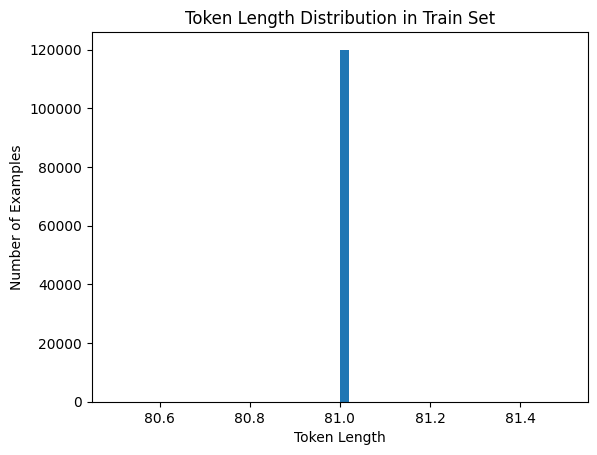

In [ ]:
# 확인
# 토큰 길이 측정
lengths = [len(example["input_ids"]) for example in train]

# 히스토그램 시각화
plt.hist(lengths, bins=50)
plt.title("Token Length Distribution in Train Set")
plt.xlabel("Token Length")
plt.ylabel("Number of Examples")
plt.show()

In [ ]:


output_dir = './'

training_arguments = TrainingArguments(
    output_dir,                        # output이 저장될 경로
    eval_strategy="epoch",             #evaluation하는 빈도
    save_strategy="epoch",
    learning_rate = 2e-5,              #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 3,              # train 시킬 총 epochs
    weight_decay = 0.01,               # weight decay: 가중치에 페널티를 주는 방식의 L2 정규화
)

In [ ]:
!pip install evaluate

In [ ]:
# mrpc와 같은 이중분류 문제이므로, mrpc metric을 그대로 사용한다. 만약, task가 달라지면 다른 metric지표를 사용해야 한다.

# from datasets import load_metric
# metric = load_metric('glue', 'mrpc')

import evaluate
metric = evaluate.load('glue', 'mrpc')

def compute_metrics(eval_pred):
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

In [ ]:
trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=train,    # training dataset
    eval_dataset=valid,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: years-archive (huggingface-helper) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.303300,0.280302,0.898467,0.897400
2,0.233600,0.364303,0.901833,0.902059
3,0.132600,0.479381,0.901500,0.901405


TrainOutput(global_step=45000, training_loss=0.23929850107828776, metrics={'train_runtime': 2145.1816, 'train_samples_per_second': 167.818, 'train_steps_per_second': 20.977, 'total_flos': 1.49849968248e+16, 'train_loss': 0.23929850107828776, 'epoch': 3.0})

In [ ]:
trainer.evaluate(test)

{'eval_loss': 0.4796539843082428,
 'eval_accuracy': 0.90138,
 'eval_f1': 0.9026936359151455,
 'eval_runtime': 79.7952,
 'eval_samples_per_second': 626.604,
 'eval_steps_per_second': 78.326,
 'epoch': 3.0}

    - eval_strategy="epoch",
    - learning_rate = 2e-5,
    - per_device_train_batch_size = 8,
    - per_device_eval_batch_size = 8,
    - num_train_epochs = 3,
    - weight_decay = 0.01,

    이 파라미터에 대해서 정확도 90% 나왔다.

### Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기

데이터 전처리, TrainingArguments 등을 조정하여 모델의 정확도를 90% 이상으로 끌어올려봅시다.


##### batch_size = 16

In [ ]:
another_model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_dir = "./another_model"

training_arguments = TrainingArguments(
    output_dir,                        # output이 저장될 경로
    eval_strategy="epoch",             # evaluation하는 빈도
    save_strategy="epoch",
    learning_rate = 2e-5,              # learning_rate
    per_device_train_batch_size = 16,   # 각 device 당 batch size
    per_device_eval_batch_size = 16,    # evaluation 시에 batch size
    num_train_epochs = 3,              # train 시킬 총 epochs
    weight_decay = 0.01,               # weight decay: 가중치에 페널티를 주는 방식의 L2 정규화
)

In [ ]:
trainer = Trainer(
    model=another_model,               # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=train,               # training dataset
    eval_dataset=valid,                # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: years-archive (huggingface-helper) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.255100,0.252230,0.901933,0.902705
2,0.184300,0.292396,0.902933,0.903435
3,0.122000,0.385521,0.904400,0.904240


TrainOutput(global_step=22500, training_loss=0.20033743777804905, metrics={'train_runtime': 1590.4214, 'train_samples_per_second': 226.355, 'train_steps_per_second': 14.147, 'total_flos': 1.49849968248e+16, 'train_loss': 0.20033743777804905, 'epoch': 3.0})

In [ ]:
trainer.evaluate(test)

{'eval_loss': 0.3955548107624054,
 'eval_accuracy': 0.90234,
 'eval_f1': 0.9033088453693986,
 'eval_runtime': 65.624,
 'eval_samples_per_second': 761.917,
 'eval_steps_per_second': 47.62,
 'epoch': 3.0}

##### batch_size = 32

In [ ]:
third_model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!mkdir ./third_model

In [ ]:
output_dir = "./third_model"

training_arguments = TrainingArguments(
    output_dir,                        # output이 저장될 경로
    eval_strategy="epoch",             # evaluation하는 빈도
    save_strategy="epoch",
    learning_rate = 2e-5,              # learning_rate
    per_device_train_batch_size = 32,   # 각 device 당 batch size
    per_device_eval_batch_size = 32,    # evaluation 시에 batch size
    num_train_epochs = 3,              # train 시킬 총 epochs
    weight_decay = 0.01,               # weight decay: 가중치에 페널티를 주는 방식의 L2 정규화
    save_total_limit=3,                # checkpoint 최신 3개만 유지
)

In [ ]:
trainer = Trainer(
    model=third_model,               # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=train,               # training dataset
    eval_dataset=valid,                # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.246700,0.243899,0.902767,0.901801
2,0.173100,0.260350,0.904200,0.905011
3,0.122200,0.315813,0.905533,0.905357


TrainOutput(global_step=11250, training_loss=0.19301375495062933, metrics={'train_runtime': 1318.2903, 'train_samples_per_second': 273.081, 'train_steps_per_second': 8.534, 'total_flos': 1.49849968248e+16, 'train_loss': 0.19301375495062933, 'epoch': 3.0})

In [ ]:
trainer.evaluate(test)

{'eval_loss': 0.31664374470710754,
 'eval_accuracy': 0.9034,
 'eval_f1': 0.9043867289571621,
 'eval_runtime': 56.4683,
 'eval_samples_per_second': 885.452,
 'eval_steps_per_second': 27.679,
 'epoch': 3.0}

##### batch_size=8, weight_decat=0.1

In [ ]:
fourth_model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!mkdir ./fourth_model

In [ ]:
output_dir = "./fourth_model"

training_arguments = TrainingArguments(
    output_dir,                        # output이 저장될 경로
    eval_strategy="epoch",             # evaluation하는 빈도
    save_strategy="epoch",
    learning_rate = 2e-5,              # learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 3,              # train 시킬 총 epochs
    weight_decay = 0.1,               # weight decay: 가중치에 페널티를 주는 방식의 L2 정규화
    save_total_limit=3,                # checkpoint 최신 3개만 유지
)

In [ ]:
trainer = Trainer(
    model=fourth_model,               # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=train,               # training dataset
    eval_dataset=valid,                # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.299300,0.286086,0.895867,0.893065
2,0.232100,0.400259,0.901500,0.902272
3,0.138300,0.469910,0.903500,0.903548


TrainOutput(global_step=45000, training_loss=0.23649422793918184, metrics={'train_runtime': 2173.877, 'train_samples_per_second': 165.603, 'train_steps_per_second': 20.7, 'total_flos': 1.49849968248e+16, 'train_loss': 0.23649422793918184, 'epoch': 3.0})

In [ ]:
trainer.evaluate(test)

{'eval_loss': 0.4717709422111511,
 'eval_accuracy': 0.90248,
 'eval_f1': 0.9037276891486337,
 'eval_runtime': 80.4818,
 'eval_samples_per_second': 621.258,
 'eval_steps_per_second': 77.657,
 'epoch': 3.0}

### Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교

아래 링크를 바탕으로 bucketing과 dynamic padding이 무엇인지 알아보고, 이들을 적용하여 model을 학습시킵니다.

- Data Collator: https://huggingface.co/docs/transformers/v4.30.0/en/main_classes/data_collator

- Trainer.TrainingArguments 의 group_by_length: https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments

STEP 4에 학습한 결과와 bucketing을 적용하여 학습시킨 결과를 비교해보고, 모델 성능 향상과 훈련 시간 두 가지 측면에서 각각 어떤 이점이 있는지 비교해봅시다.

In [ ]:
!mkdir ./results

In [ ]:
fifth_model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)  # dynamic padding 적용

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",         # 매 epoch 저장
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    group_by_length=True,  # 🔥 Bucketing 핵심 옵션
)

trainer = Trainer(
    model=fifth_model,
    args=training_args,
    train_dataset=train,
    eval_dataset=valid,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator  # dynamic padding
)

trainer.train()


<ipython-input-44-11cb96887d66>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.297900,0.280490,0.897500,0.898088
2,0.234000,0.360194,0.903500,0.901714
3,0.132000,0.467950,0.904167,0.904773


TrainOutput(global_step=45000, training_loss=0.23798619435628254, metrics={'train_runtime': 2215.014, 'train_samples_per_second': 162.527, 'train_steps_per_second': 20.316, 'total_flos': 1.49849968248e+16, 'train_loss': 0.23798619435628254, 'epoch': 3.0})

In [ ]:
trainer.evaluate(test)

{'eval_loss': 0.4740499258041382,
 'eval_accuracy': 0.9021,
 'eval_f1': 0.9039310737346182,
 'eval_runtime': 81.5607,
 'eval_samples_per_second': 613.04,
 'eval_steps_per_second': 76.63,
 'epoch': 3.0}

# 회고

Test set에 대한 결과 비교

| 구분 | loss | accuracy | f1 |
| --- | --- | --- | --- |
|bsz = 8, wd = 0.01  | 0.4797 | 0.9014 | 0.9027 |
|bsz = 16, wd = 0.01 | 0.3956 | 0.9023 | 0.9033 |
|bsz = 32, wd = 0.01 | 0.3166 | 0.9034 | 0.9044 |
|bsz = 8, wd = 0.1   | 0.4718 | 0.9025 | 0.9037 |




batch size가 클수록 학습 속도가 줄고, 미세하게 성능 향상을 보이는 것을 확인했다.  

weight decay를 0.01 -> 0.1로 변경했을때, 성능 향상을 보이지 않았다.

bucketing 적용 전 35:29에 비해 bucketing 적용 후, 36:54는 학습 속도가 오히려 늘어났다.  확인이 필요하다.


코랩 A100 GPU가 속도가 엄청 빨라서, 프로젝트를 시간안에 마무리 할 수 있었다.  



### result archive



#### batch_size = 8, weight_decay = 0.01

Train  

[45000/45000 35:29, Epoch 3/3]

| Epoch |	Training Loss |	Validation Loss |	Accuracy |	F1 |
| --- | --- | --- | --- | --- |
| 1 |	0.303300 |	0.280302 |	0.898467	| 0.897400 |
| 2 |	0.233600 |	0.364303 |	0.901833	| 0.902059 |
| 3 |	0.132600 |	0.479381 |	0.901500	| 0.901405 |

Test

[6250/6250 01:19]  
```
{'eval_loss': 0.4796539843082428,
 'eval_accuracy': 0.90138,
 'eval_f1': 0.9026936359151455,
 'eval_runtime': 79.7952,
 'eval_samples_per_second': 626.604,
 'eval_steps_per_second': 78.326,
 'epoch': 3.0}
```

---

#### batch_size = 16, weight_decay = 0.01
Train  

[22500/22500 26:27, Epoch 3/3]

| Epoch |	Training Loss | 	Validation Loss |	Accuracy	| F1 |
| --- | --- | --- | --- | --- |
| 1 |	0.255100 | 	0.252230 |	0.901933	| 0.902705 |
| 2 |	0.184300 | 	0.292396 |	0.902933	| 0.903435 |
| 3 |	0.122000 | 	0.385521 |	0.904400	| 0.904240 |

Test  
[3125/3125 01:05]
```
{'eval_loss': 0.3955548107624054,
 'eval_accuracy': 0.90234,
 'eval_f1': 0.9033088453693986,
 'eval_runtime': 65.624,
 'eval_samples_per_second': 761.917,
 'eval_steps_per_second': 47.62,
 'epoch': 3.0}
```

---

#### batch_size = 32, weight_decay = 0.01

Train  

[11250/11250 21:58, Epoch 3/3]

|Epoch |	Training Loss |	Validation Loss |	Accuracy |	F1 |
| --- | --- | --- | --- | --- |
|1 |	0.246700 |	0.243899 |	0.902767 |	0.901801 |
|2 |	0.173100 |	0.260350 |	0.904200 |	0.905011 |
|3 |	0.122200 |	0.315813 |	0.905533 |	0.905357 |

Test  

[1563/1563 00:56]

```
{'eval_loss': 0.31664374470710754,
 'eval_accuracy': 0.9034,
 'eval_f1': 0.9043867289571621,
 'eval_runtime': 56.4683,
 'eval_samples_per_second': 885.452,
 'eval_steps_per_second': 27.679,
 'epoch': 3.0}
```

---

#### batch_size = 8, weight_decay = 0.1

Train  

[45000/45000 36:13, Epoch 3/3]

| Epoch |	Training Loss |	Validation Loss |	Accuracy |	F1 |
| --- | --- | --- | --- | --- |
| 1 |	0.299300 |	0.286086 |	0.895867	| 0.893065 |
| 2 |	0.232100 |	0.400259 |	0.901500	| 0.902272 |
| 3 |	0.138300 |	0.469910 |	0.903500	| 0.903548 |

Test

[6250/6250 01:20]

```
{'eval_loss': 0.4717709422111511,
 'eval_accuracy': 0.90248,
 'eval_f1': 0.9037276891486337,
 'eval_runtime': 80.4818,
 'eval_samples_per_second': 621.258,
 'eval_steps_per_second': 77.657,
 'epoch': 3.0}
```

## bucketing & dynamic padding 개념이해



좋은 질문입니다! `bucketing`과 `dynamic padding`은 자연어 처리(NLP) 모델 학습에서 **효율적인 배치 처리(batch processing)** 를 위해 사용되는 **텍스트 길이 최적화 기법**입니다. 아래에서 개념과 차이를 쉽게 설명드릴게요.

---

### ✅ 1. Dynamic Padding (동적 패딩)

#### 📌 개념:

* **동적(dynamic)** 으로, **각 배치 내에서 가장 긴 문장 길이에 맞춰 padding**을 하는 방식입니다.
* → 전체 데이터셋에서 가장 긴 문장에 맞춰 패딩하지 않기 때문에 **메모리 낭비가 적습니다.**

#### ✅ 예시:

```python
Batch 1: ["나는 밥을 먹었다", "배고파"]
→ 토큰 길이: [5, 3] → max_len = 5 → [5, 5]로 패딩

Batch 2: ["오전에는 공부하고", "저녁에 운동함", "그리고 잠"]
→ 토큰 길이: [5, 4, 3] → max_len = 5 → [5, 5, 5]로 패딩
```

#### ✅ 장점:

* GPU 메모리 사용이 최적화됨
* 전체 max length로 패딩하는 것보다 연산량 ↓

---

### ✅ 2. Bucketing (버킷팅)

#### 📌 개념:

* **유사한 길이의 문장들끼리 묶어서(mini-batch로)** 학습하는 방식입니다.
* → 패딩이 거의 필요 없도록 **비슷한 길이의 문장들만 묶기 때문에 효율적입니다.**

#### ✅ 작동 방식:

1. 전체 데이터를 문장 길이에 따라 정렬
2. 비슷한 길이의 데이터끼리 묶어 "버킷(bucket)" 생성
3. 각 버킷에서 배치를 구성하여 학습

#### ✅ 예시:

```plaintext
길이별로 정렬 후
[3, 3, 4] → Batch 1
[10, 9, 11] → Batch 2
```

#### ✅ 장점:

* padding이 거의 필요 없음
* 연산 자원 절약

---

### ✅ 둘의 차이 요약

| 항목        | Dynamic Padding | Bucketing                    |
| --------- | --------------- | ---------------------------- |
| 패딩 기준     | **각 배치의 최대 길이** | **유사한 길이끼리 묶기 때문에 패딩 거의 없음** |
| 구현 난이도    | 간단함             | 상대적으로 복잡함 (bucket 나눠야 함)     |
| 메모리 효율    | 좋음              | **더 좋음**                     |
| 데이터 순서 보존 | 가능              | 대부분 순서 섞임 (shuffle 필요)       |

---

### ✅ Hugging Face에서 적용 예시

```python
from transformers import DataCollatorWithPadding

# Dynamic Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=data_collator,
)
```

> 🤖 `DataCollatorWithPadding`은 내부적으로 dynamic padding을 자동 처리해 줍니다.

---

원한다면 PyTorch DataLoader에서 bucketing을 수동 구현하는 방법도 알려드릴 수 있어요.
